In [27]:
import visual_behavior.data_access.loading as loading
from visual_behavior.translator.foraging2 import data_to_change_detection_core
from visual_behavior.translator.foraging import data_to_change_detection_core as data_to_change_detection_core_legacy
import visual_behavior.database as db
from visual_behavior import analyze

import scipy.signal as signal

from allensdk.brain_observatory.behavior import running_processing

from allensdk.brain_observatory.behavior.behavior_session import BehaviorSession

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import figrid as fg

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
%matplotlib notebook

In [4]:
def load_running_df(bsid=None,pkl_path=None,camstim_type='foraging2'):
    '''
    loads running data from pkl file using VBA
    input is either the behavior session ID (bsid) or the pkl path (not both!)
    '''
    if bsid:
        pkl_path = db.get_pkl_path(int(bsid))
    
    data = pd.read_pickle(pkl_path)
    if camstim_type == 'foraging2':
        core_data = data_to_change_detection_core(data)
    else:
        core_data = data_to_change_detection_core_legacy(data)
    return core_data['running']

In [28]:
bsid = 938991494
running_df = load_running_df(bsid)
session = BehaviorSession.from_lims(bsid)

In [6]:
running_df

,time,frame,speed,dx,v_sig,v_in
0,0.000000,0,36.034462,31.178823,1.306682,4.993889
1,0.016641,1,35.945263,3.632217,1.357068,4.993889
2,0.033366,2,35.908909,7.971112,1.466883,4.991305
3,0.050041,3,35.967435,6.243192,1.553443,4.991305
4,0.066711,4,35.217195,5.556751,1.628376,4.984845
...,...,...,...,...,...,...
269912,4502.292118,269912,-0.112655,-0.312632,1.767906,4.991305
269913,4502.308844,269913,-0.363652,0.213426,1.771782,4.993889
269914,4502.325526,269914,-0.268601,0.126209,1.773074,4.992597
269915,4502.342161,269915,0.000000,-0.174397,1.767906,4.984845


In [9]:
pos_wraps, neg_wraps = running_processing._identify_wraps(running_df['v_sig'], min_threshold=1.5, max_threshold=3.5)
running_df['unwrapped_vsig'] = running_processing._unwrap_voltage_signal(running_df['v_sig'], pos_wraps, neg_wraps, max_threshold=5.1, max_diff=1.0)

running_df['angular_change_point'] = running_processing._angular_change(running_df['unwrapped_vsig'], running_df['v_in'])
running_df['angular_change'] = np.nancumsum(running_df['angular_change_point'])
running_df['angular_speed'] = running_processing.calc_deriv(running_df['angular_change'], running_df['time'])
running_df['linear_speed'] = running_processing.deg_to_dist(running_df['angular_speed'])


zscore_threshold=10.0

running_df['wrap_corrected_linear_speed'] = running_processing._clip_speed_wraps(running_df['linear_speed'], running_df['time'], np.concatenate([pos_wraps, neg_wraps]),t_span=0.25)
running_df['outlier_corrected_linear_speed'] = running_processing._zscore_threshold_1d(running_df['wrap_corrected_linear_speed'], threshold=zscore_threshold)

b, a = signal.butter(3, Wn=4, fs=60, btype="lowpass")
running_df['filtered_linear_speed'] = signal.filtfilt(b, a, np.nan_to_num(running_df['outlier_corrected_linear_speed']))

/home/dougo/anaconda3/envs/vba/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


## plot raw signals:

In [10]:
running_sample = running_df.query('time >= 1540 and time <= 1550').copy().reset_index()
running_sample['local_time'] = running_sample['time'] - running_sample['time'].iloc[0]

<IPython.core.display.Javascript object>


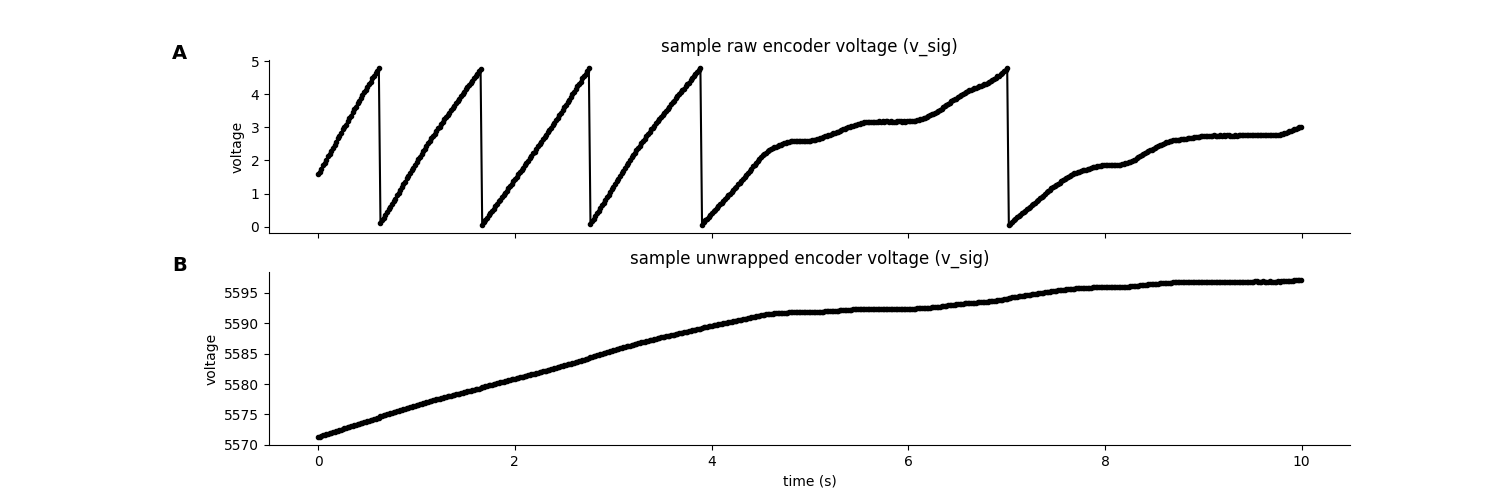

In [26]:
fig = plt.figure(figsize = (15,5))
ax = {
        'panel_A': fg.place_axes_on_grid(fig, xspan=[0.075, 1], yspan=[0.0, 0.45]),
        'panel_B': fg.place_axes_on_grid(fig, xspan=[0.075, 1], yspan=[0.55, 1],),
    }

labels = [
    {'label_text':'A', 'xpos':0,    'ypos':0.0, 'fontsize':14, 'weight': 'bold', 'ha': 'right', 'va': 'bottom'},
    {'label_text':'B', 'xpos':0,    'ypos':0.55, 'fontsize':14, 'weight': 'bold', 'ha': 'right', 'va': 'bottom'},
]


ax['panel_A'].plot(
    running_sample['local_time'],
    running_sample['v_sig'],
    marker='.',
    color='black'
)

ax['panel_A'].set_xticklabels([])
ax['panel_A'].set_ylabel('voltage')
ax['panel_A'].set_title('sample raw encoder voltage (v_sig)')

ax['panel_B'].set_xlabel('time (s)')
ax['panel_B'].set_ylabel('voltage')
ax['panel_B'].set_title('sample unwrapped encoder voltage (v_sig)')


ax['panel_B'].plot(
    running_sample['local_time'],
    running_sample['unwrapped_vsig'],
    marker='.',
    color='black'
)

fg.add_labels(fig, labels)

sns.despine()

## plot speed (before and after filtering)

In [12]:
running_sample

,index,time,frame,speed,dx,v_sig,v_in,unwrapped_vsig,angular_change_point,angular_change,angular_speed,linear_speed,wrap_corrected_linear_speed,outlier_corrected_linear_speed,filtered_linear_speed,local_time
0,92323,1540.002219,92323,33.377122,7.831340,1.580574,4.988721,5571.267305,0.136683,7014.241354,8.173284,44.980304,44.980304,44.980304,37.196618,0.000000
1,92324,1540.018899,92324,34.581784,5.997870,1.661967,4.983553,5571.348698,0.102618,7014.343973,6.152249,33.857877,33.857877,33.857877,37.305807,0.016680
2,92325,1540.035537,92325,34.538877,5.501965,1.739483,4.987429,5571.426214,0.097656,7014.441628,5.869247,32.300425,32.300425,32.300425,37.401666,0.033318
3,92326,1540.052259,92326,34.942330,8.171744,1.853174,4.988721,5571.539905,0.143191,7014.584820,8.563386,47.127170,47.127170,47.127170,37.485716,0.050040
4,92327,1540.068942,92327,35.479792,5.666014,1.930691,4.986137,5571.617422,0.097681,7014.682501,5.854811,32.220975,32.220975,32.220975,37.559756,0.066724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,92918,1549.927149,92918,9.007277,1.586146,2.940991,4.984845,5597.035170,0.027683,7046.691180,1.657201,9.120127,9.120127,9.120127,8.389553,9.924930
596,92919,1549.943851,92919,8.900276,1.160755,2.961662,4.992597,5597.055841,0.026015,7046.717195,1.557569,8.571823,8.571823,8.571823,8.454524,9.941632
597,92920,1549.960531,92920,8.596590,1.676841,2.984917,4.992597,5597.079096,0.029266,7046.746461,1.754571,9.655987,9.655987,9.655987,8.566565,9.958312
598,92921,1549.977190,92921,8.590583,1.546622,3.005588,4.991305,5597.099767,0.026021,7046.772483,1.561995,8.596177,8.596177,8.596177,8.760760,9.974971


<IPython.core.display.Javascript object>


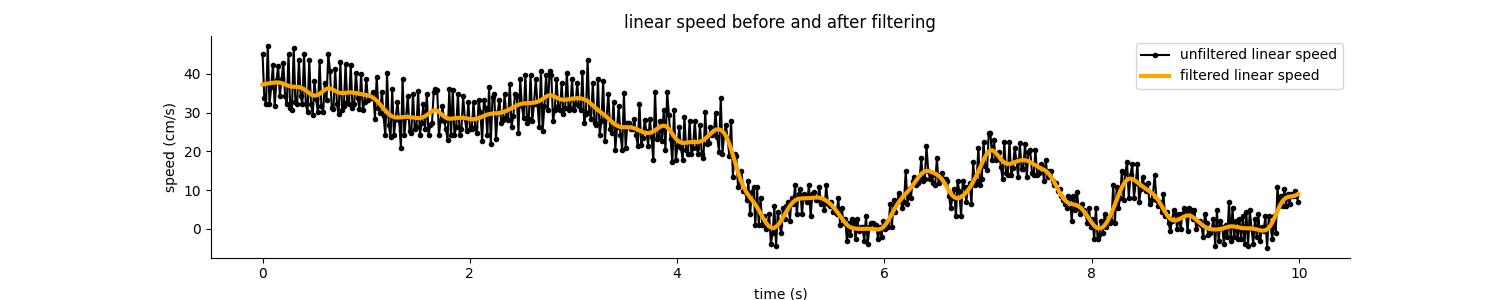

In [38]:
fig = plt.figure(figsize = (15,3))
ax = {
        'panel_A': fg.place_axes_on_grid(fig, xspan=[0.025, 1], yspan=[0.0, 0.96]),
    }

labels = [
    {'label_text':'A', 'xpos':0,    'ypos':0.0, 'fontsize':14, 'weight': 'bold', 'ha': 'right', 'va': 'bottom'},
]



ax['panel_A'].plot(
    running_sample['local_time'],
    running_sample['outlier_corrected_linear_speed'],
    marker='.',
    color = 'black'
)

ax['panel_A'].plot(
    running_sample['local_time'],
    running_sample['filtered_linear_speed'],
    linewidth = 3,
    color='orange'
)

ax['panel_A'].legend(['unfiltered linear speed','filtered linear speed'])

ax['panel_A'].set_xlabel('time (s)')
ax['panel_A'].set_ylabel('speed (cm/s)')
ax['panel_A'].set_title('linear speed before and after filtering')

sns.despine()

In [33]:
running_sample_sdk_raw = session.raw_running_speed.query('timestamps >= 1540 and timestamps <= 1550').copy().reset_index()
running_sample_sdk_raw['local_time'] = running_sample_sdk_raw['timestamps'] - running_sample_sdk_raw['timestamps'].iloc[0]

running_sample_sdk = session.running_speed.query('timestamps >= 1540 and timestamps <= 1550').copy().reset_index()
running_sample_sdk['local_time'] = running_sample_sdk['timestamps'] - running_sample_sdk['timestamps'].iloc[0]

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/behavior/running_processing.py:365: UserWarning: Time array is 1 value shorter than encoder array. Last encoder value removed

  "value removed\n", UserWarning, stacklevel=1)


<IPython.core.display.Javascript object>


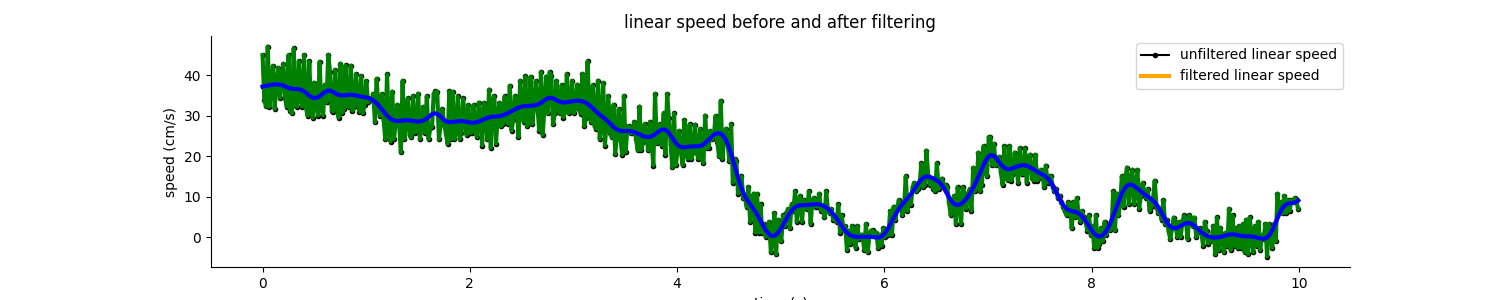

In [37]:
fig = plt.figure(figsize = (15,3))
ax = {
        'panel_A': fg.place_axes_on_grid(fig, xspan=[0.025, 1], yspan=[0.0, 1]),
    }

labels = [
    {'label_text':'A', 'xpos':0,    'ypos':0.0, 'fontsize':14, 'weight': 'bold', 'ha': 'right', 'va': 'bottom'},
]



ax['panel_A'].plot(
    running_sample['local_time'],
    running_sample['outlier_corrected_linear_speed'],
    marker='.',
    color = 'black'
)

ax['panel_A'].plot(
    running_sample['local_time'],
    running_sample['filtered_linear_speed'],
    linewidth = 3,
    color='orange'
)

ax['panel_A'].plot(
    running_sample_sdk_raw['local_time'],
    running_sample_sdk_raw['speed'],
    linewidth = 3,
    color='green'
)

ax['panel_A'].plot(
    running_sample_sdk['local_time'],
    running_sample_sdk['speed'],
    linewidth = 3,
    color='blue'
)

ax['panel_A'].legend(['unfiltered linear speed','filtered linear speed'])

ax['panel_A'].set_xlabel('time (s)')
ax['panel_A'].set_ylabel('speed (cm/s)')
ax['panel_A'].set_title('linear speed before and after filtering')

sns.despine()

In [35]:
running_sample_sdk

,index,timestamps,speed,local_time
0,92323,1540.002219,37.196618,0.000000
1,92324,1540.018899,37.305807,0.016680
2,92325,1540.035537,37.401666,0.033318
3,92326,1540.052259,37.485716,0.050040
4,92327,1540.068942,37.559756,0.066724
...,...,...,...,...
595,92918,1549.927149,8.389553,9.924930
596,92919,1549.943851,8.454524,9.941632
597,92920,1549.960531,8.566565,9.958312
598,92921,1549.977190,8.760760,9.974971
